# ERA5-Land

In [24]:
from zonal_variograms.backend import rasterio

import geopandas as gpd
import rasterio

In [25]:
runoff = rasterio.open('netcdf:dev/data.nc:ro')
segments = gpd.read_file('dev/GRDC_DE_336.gpkg')

In [4]:
ds = rio.open_rasterio('dev/data.nc', mask_and_scale=True)
ds.rio.write_crs("epsg:4326", inplace=True)
ds.rio.crs
type(ds)

xarray.core.dataset.Dataset

In [8]:
from geocube.api.core import make_geocube

In [6]:
# build a geocube
segments["oid"] = segments.index

cube = make_geocube(
    vector_data=segments,
    measurements=["oid"],
    like=ds
)

cube["ro"] = ds.ro
cube["tp"] = ds.tp
cube

<xarray.Dataset>
Dimensions:      (y: 77, x: 91, time: 744)
Coordinates:
  * y            (y) float64 54.9 54.8 54.7 54.6 54.5 ... 47.6 47.5 47.4 47.3
  * x            (x) float64 5.98 6.08 6.18 6.28 ... 14.68 14.78 14.88 14.98
    spatial_ref  int64 0
  * time         (time) object 2022-03-01 00:00:00 ... 2022-03-31 23:00:00
Data variables:
    oid          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    ro           (time, y, x) float32 ...
    tp           (time, y, x) float32 ...

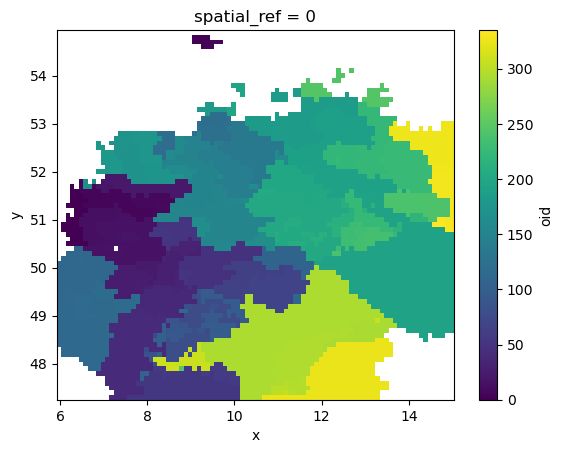

In [7]:
cube.oid.plot.imshow()

<Axes: >

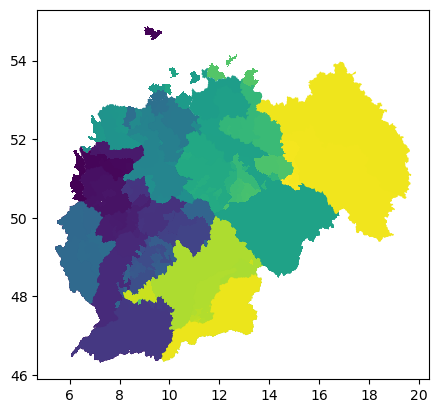

In [8]:
segments.plot(column='oid')

In [9]:
import numpy as np

np.unique(cube.oid.data)

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  14.,
        16.,  17.,  18.,  19.,  20.,  23.,  24.,  26.,  27.,  28.,  30.,
        31.,  32.,  33.,  34.,  35.,  38.,  39.,  40.,  48.,  49.,  50.,
        51.,  52.,  53.,  54.,  55.,  57.,  59.,  60.,  61.,  63.,  64.,
        65.,  66.,  67.,  73.,  75.,  76.,  77.,  78.,  81.,  82.,  83.,
        84.,  85.,  86.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  97.,
        98.,  99., 100., 101., 102., 103., 104., 105., 106., 107., 108.,
       109., 110., 111., 112., 113., 114., 115., 116., 117., 118., 119.,
       120., 121., 123., 124., 134., 135., 143., 148., 150., 151., 152.,
       153., 154., 155., 156., 157., 158., 159., 160., 161., 162., 163.,
       165., 166., 167., 172., 173., 174., 175., 176., 177., 178., 179.,
       180., 181., 182., 183., 184., 185., 189., 190., 192., 193., 195.,
       197., 198., 201., 202., 203., 204., 205., 206., 207., 208., 209.,
       210., 211., 212., 213., 214., 215., 216., 21

In [10]:
grp_cube = cube.groupby(cube.oid)
df = grp_cube.mean().drop("spatial_ref").to_dataframe()

aggregator = getattr(grp_cube, 'mean')
df = aggregator().to_dataframe().drop('spatial_refs', axis=1, errors='ignore')

#pd.merge(grp_cube.mean().to_dataframe(), grp_cube.std().to_dataframe(), left_index=True, right_index=True, suffixes=('_mean', '_std'))
df

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


spatial_ref        ro            tp
oid   time                                                    
0.0   2022-03-01 00:00:00            0  0.001892  7.795170e-07
      2022-03-01 01:00:00            0  0.000079 -9.313226e-10
      2022-03-01 02:00:00            0  0.000158 -9.313226e-10
      2022-03-01 03:00:00            0  0.000237 -9.313226e-10
      2022-03-01 04:00:00            0  0.000317 -9.313226e-10
...                                ...       ...           ...
335.0 2022-03-31 19:00:00            0  0.001223  6.012780e-04
      2022-03-31 20:00:00            0  0.001287  6.164446e-04
      2022-03-31 21:00:00            0  0.001351  6.349906e-04
      2022-03-31 22:00:00            0  0.001415  6.557034e-04
      2022-03-31 23:00:00            0  0.001478  7.136823e-04

[143592 rows x 3 columns]

In [11]:
original_index = df.index.names
original_index
for oid, grp in df.reset_index().set_index([_ for _ in df.index.names if _ != 'oid']).groupby('oid'):
    print(oid)
    print(grp.shape)
    break

0.0
(744, 4)


In [31]:
#df.reset_index().set_index('time').groupby('oid').mean()
for oid, d in df.groupby('oid'):
    d = d.reset_index().drop('oid', axis=1)
    print(d.set_index('time').mean())

    break

segments.join(df.reset_index().set_index('time').groupby('oid').agg({'ro': 'sum', 'tp': 'median'}))

spatial_ref    0.000000
ro             0.000902
tp             0.000376
dtype: float64


,gauge_id,geometry,oid,ro,tp
0.0,GRDC_6321100,"MULTIPOLYGON (((6.20833 51.72083, 6.24167 51.7...",0,0.671309,7.795170e-07
1.0,GRDC_6321200,"MULTIPOLYGON (((6.19167 51.11250, 6.20000 51.1...",1,0.766474,1.070555e-06
2.0,GRDC_6334270,"MULTIPOLYGON (((9.10833 54.86667, 9.12500 54.8...",2,0.941034,7.795170e-07
3.0,GRDC_6334280,"MULTIPOLYGON (((9.10833 54.86667, 9.12500 54.8...",3,0.964230,7.795170e-07
4.0,GRDC_6334800,"MULTIPOLYGON (((9.52500 54.77917, 9.53750 54.7...",4,0.909278,7.795170e-07
...,...,...,...,...,...
331.0,GRDC_6357503,"MULTIPOLYGON (((14.81667 50.87500, 14.82917 50...",331,NaN,NaN
332.0,GRDC_6357505,"MULTIPOLYGON (((15.08750 50.87083, 15.10000 50...",332,1.037246,9.094365e-07
333.0,GRDC_6357510,"MULTIPOLYGON (((14.89167 51.09583, 14.90833 51...",333,0.682019,8.444767e-07
334.0,GRDC_6357520,"MULTIPOLYGON (((14.64167 51.00833, 14.66667 51...",334,NaN,NaN


In [1]:
# clip to the regio where oid is 5
cube.where(cube.oid == 5).ro.to_masked_array().mean(axis=(1,2))

NameError: name 'cube' is not defined

In [80]:
for dim in cube.dims.keys():
    print(dim)

y
x
time


In [71]:
cube.where(cube.oid == 5).dropna('x', how='all').dropna('y', how='all').coords

Coordinates:
  * y            (y) float64 51.8 51.7 51.6 51.5 51.4 51.3
  * x            (x) float64 6.48 6.58 6.68 6.78 6.88 ... 7.28 7.38 7.48 7.58
    spatial_ref  int64 0
  * time         (time) object 2022-03-01 00:00:00 ... 2022-03-31 23:00:00

In [113]:
clip.to_netcdf('test.nc')

# Mussels

In [14]:
import rioxarray as rio
import xarray as xr
import geopandas as gpd

ds = rio.open_rasterio('dev/unioc_ft-kal-d6_sem_0_modified.tif', mask_and_scale=True)
mussl = gpd.read_file('dev/Unioc.gpkg')
ds = xr.Dataset({'unioc': ds})
ds

<xarray.Dataset>
Dimensions:      (band: 1, x: 6977, y: 6425)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 0.05791 0.1737 0.2896 0.4054 ... 807.8 807.9 808.1
  * y            (y) float64 -0.05791 -0.1737 -0.2896 ... -743.9 -744.0 -744.1
    spatial_ref  int64 0
Data variables:
    unioc        (band, y, x) float32 ...

In [15]:
from zonal_variograms import main
clips = main.clip_features_from_dataset(ds, mussl)

21it [00:06,  3.34it/s]


In [27]:
with_overlay = main.add_oid_overlay(ds, mussl)
aggregates = main.univariate_by_oid(with_overlay)
aggregates

,,unioc_mean,unioc_std,unioc_min,unioc_max,unioc_median,unioc_sum
oid,band,,,,,,
0.0,1,136.522705,51.219273,0.0,255.0,147.0,1957326.0
1.0,1,137.022690,49.031513,0.0,255.0,146.0,5990221.0
2.0,1,138.306778,46.552006,0.0,255.0,147.0,6233210.0
3.0,1,136.841064,50.537067,0.0,254.0,148.0,5213508.0
4.0,1,139.171295,47.042061,0.0,255.0,148.0,6032658.0
5.0,1,138.927292,52.554523,0.0,255.0,148.0,5145311.0
6.0,1,139.577469,48.054153,0.0,255.0,149.0,5638930.0
7.0,1,138.453384,48.784920,0.0,255.0,149.0,5618300.0
8.0,1,138.594131,51.058140,0.0,255.0,150.0,5932106.0


# hyras test

In [1]:
import rioxarray as rio
import xarray as xr

# This all only works when the hyras crs is set by hand and the Dataset is build from the DataArray with the variable of interest
pr = xr.open_dataset('dev/pr_hyras_1_2023_v5-0_de.nc', mask_and_scale=True, decode_coords="all").pr

#ds.rio.write_crs("epsg:4326", inplace=True)
pr.rio.set_spatial_dims(x_dim="x", y_dim="y", inplace=True)
pr.rio.write_crs("epsg:3034", inplace=True)
#pr.drop('crs_HYRAS', inplace=True)
ds = xr.Dataset({'pr': pr})

ds

<xarray.Dataset>
Dimensions:    (time: 323, y: 1100, x: 1200)
Coordinates:
  * time       (time) datetime64[ns] 2023-01-01T18:00:00 ... 2023-11-19T18:00:00
    lon        (y, x) float64 ...
    lat        (y, x) float64 ...
  * x          (x) float32 3.5e+06 3.502e+06 3.502e+06 ... 4.698e+06 4.7e+06
  * y          (y) float32 2.1e+06 2.102e+06 2.102e+06 ... 3.198e+06 3.2e+06
    crs_HYRAS  int64 0
Data variables:
    pr         (time, y, x) float32 ...

<Axes: >

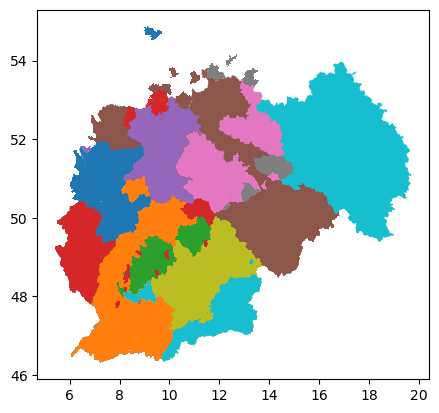

In [2]:
import geopandas as gpd
segments = gpd.read_file('dev/GRDC_DE_336.gpkg')


segments.plot(column='gauge_id')

In [3]:
from zonal_variograms import main as cube_backend

#clips = cube_backend.clip_features_from_dataset(ds, segments, n_jobs=3, use_oids=[1,2,3,40,41,43])
clips = cube_backend.clip_features_from_dataset(ds, segments, n_jobs=2, use_oids=[44])

1it [00:04,  4.83s/it]


In [15]:
# aggregates for first clip
aggs = cube_backend.univariate_by_oid(clips[0])
aggs

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast


crs_HYRAS_mean    pr_mean  crs_HYRAS_std    pr_std  \
oid  time                                                                      
44.0 2023-01-01 18:00:00               0   0.000000              0  0.000000   
     2023-01-02 18:00:00               0   0.000000              0  0.000000   
     2023-01-03 18:00:00               0   0.013669              0  0.034352   
     2023-01-04 18:00:00               0   1.559712              0  0.336020   
     2023-01-05 18:00:00               0   0.425180              0  0.182348   
...                                  ...        ...            ...       ...   
     2023-11-15 18:00:00               0   4.563312              0  0.465059   
     2023-11-16 18:00:00               0  16.962589              0  2.521370   
     2023-11-17 18:00:00               0   2.323742              0  0.621044   
     2023-11-18 18:00:00               0  10.481296              0  0.543181   
     2023-11-19 18:00:00               0   0.701439              0  0.570748   

                          crs_HYRAS_min  pr_min  crs_HYRAS_max     pr_max  \
oid  time                                                                   
44.0 2023-01-01 18:00:00              0     0.0              0   0.000000   
     2023-01-02 18:00:00              0     0.0              0   0.000000   
     2023-01-03 18:00:00              0     0.0              0   0.100000   
     2023-01-04 18:00:00              0     1.0              0   2.300000   
     2023-01-05 18:00:00              0     0.2              0   0.800000   
...                                 ...     ...            ...        ...   
     2023-11-15 18:00:00              0     3.9              0   5.900000   
     2023-11-16 18:00:00              0    12.9              0  21.799999   
     2023-11-17 18:00:00              0     1.5              0   3.600000   
     2023-11-18 18:00:00              0     9.4              0  12.000000   
     2023-11-19 18:00:00              0     0.1              0   2.800000   

                          crs_HYRAS_median  pr_median  crs_HYRAS_sum  \
oid  time                                                              
44.0 2023-01-01 18:00:00                 0        0.0              0   
     2023-01-02 18:00:00                 0        0.0              0   
     2023-01-03 18:00:00                 0        0.0              0   
     2023-01-04 18:00:00                 0        1.5              0   
     2023-01-05 18:00:00                 0        0.4              0   
...                                    ...        ...            ...   
     2023-11-15 18:00:00                 0        4.4              0   
     2023-11-16 18:00:00                 0       16.5              0   
     2023-11-17 18:00:00                 0        2.3              0   
     2023-11-18 18:00:00                 0       10.4              0   
     2023-11-19 18:00:00                 0        0.6              0   

                               pr_sum  
oid  time                              
44.0 2023-01-01 18:00:00     0.000000  
     2023-01-02 18:00:00     0.000000  
     2023-01-03 18:00:00     1.900000  
     2023-01-04 18:00:00   216.800018  
     2023-01-05 18:00:00    59.100033  
...                               ...  
     2023-11-15 18:00:00   634.300293  
     2023-11-16 18:00:00  2357.799805  
     2023-11-17 18:00:00   323.000153  
     2023-11-18 18:00:00  1456.900024  
     2023-11-19 18:00:00    97.499962  

[323 rows x 12 columns]

,gauge_id,geometry,oid
0,GRDC_6321100,"MULTIPOLYGON (((6.20833 51.72083, 6.24167 51.7...",0
1,GRDC_6321200,"MULTIPOLYGON (((6.19167 51.11250, 6.20000 51.1...",1
2,GRDC_6334270,"MULTIPOLYGON (((9.10833 54.86667, 9.12500 54.8...",2
3,GRDC_6334280,"MULTIPOLYGON (((9.10833 54.86667, 9.12500 54.8...",3
4,GRDC_6334800,"MULTIPOLYGON (((9.52500 54.77917, 9.53750 54.7...",4
...,...,...,...
331,GRDC_6357503,"MULTIPOLYGON (((14.81667 50.87500, 14.82917 50...",331
332,GRDC_6357505,"MULTIPOLYGON (((15.08750 50.87083, 15.10000 50...",332
333,GRDC_6357510,"MULTIPOLYGON (((14.89167 51.09583, 14.90833 51...",333
334,GRDC_6357520,"MULTIPOLYGON (((14.64167 51.00833, 14.66667 51...",334


In [16]:
aggs.to_parquet('aggs.parquet')

In [22]:
import pandas as pd
old = pd.read_parquet('aggs.parquet')

pd.concat([old, aggs], axis=0)

crs_HYRAS_mean    pr_mean  crs_HYRAS_std    pr_std  \
oid  time                                                                      
44.0 2023-01-01 18:00:00               0   0.000000              0  0.000000   
     2023-01-02 18:00:00               0   0.000000              0  0.000000   
     2023-01-03 18:00:00               0   0.013669              0  0.034352   
     2023-01-04 18:00:00               0   1.559712              0  0.336020   
     2023-01-05 18:00:00               0   0.425180              0  0.182348   
...                                  ...        ...            ...       ...   
     2023-11-15 18:00:00               0   4.563312              0  0.465059   
     2023-11-16 18:00:00               0  16.962589              0  2.521370   
     2023-11-17 18:00:00               0   2.323742              0  0.621044   
     2023-11-18 18:00:00               0  10.481296              0  0.543181   
     2023-11-19 18:00:00               0   0.701439              0  0.570748   

                          crs_HYRAS_min  pr_min  crs_HYRAS_max     pr_max  \
oid  time                                                                   
44.0 2023-01-01 18:00:00              0     0.0              0   0.000000   
     2023-01-02 18:00:00              0     0.0              0   0.000000   
     2023-01-03 18:00:00              0     0.0              0   0.100000   
     2023-01-04 18:00:00              0     1.0              0   2.300000   
     2023-01-05 18:00:00              0     0.2              0   0.800000   
...                                 ...     ...            ...        ...   
     2023-11-15 18:00:00              0     3.9              0   5.900000   
     2023-11-16 18:00:00              0    12.9              0  21.799999   
     2023-11-17 18:00:00              0     1.5              0   3.600000   
     2023-11-18 18:00:00              0     9.4              0  12.000000   
     2023-11-19 18:00:00              0     0.1              0   2.800000   

                          crs_HYRAS_median  pr_median  crs_HYRAS_sum  \
oid  time                                                              
44.0 2023-01-01 18:00:00                 0        0.0              0   
     2023-01-02 18:00:00                 0        0.0              0   
     2023-01-03 18:00:00                 0        0.0              0   
     2023-01-04 18:00:00                 0        1.5              0   
     2023-01-05 18:00:00                 0        0.4              0   
...                                    ...        ...            ...   
     2023-11-15 18:00:00                 0        4.4              0   
     2023-11-16 18:00:00                 0       16.5              0   
     2023-11-17 18:00:00                 0        2.3              0   
     2023-11-18 18:00:00                 0       10.4              0   
     2023-11-19 18:00:00                 0        0.6              0   

                               pr_sum  
oid  time                              
44.0 2023-01-01 18:00:00     0.000000  
     2023-01-02 18:00:00     0.000000  
     2023-01-03 18:00:00     1.900000  
     2023-01-04 18:00:00   216.800018  
     2023-01-05 18:00:00    59.100033  
...                               ...  
     2023-11-15 18:00:00   634.300293  
     2023-11-16 18:00:00  2357.799805  
     2023-11-17 18:00:00   323.000153  
     2023-11-18 18:00:00  1456.900024  
     2023-11-19 18:00:00    97.499962  

[646 rows x 12 columns]

In [42]:
# save back

clips[0].copy().to_netcdf('dev/hyras_oid_44.nc')

In [28]:
import numpy as np
import matplotlib.pyplot as plt

#plt.imshow(np.nansum(clips[0].values, axis=0), origin='lower', cmap='Blues')
#plt.colorbar()

<xarray.Dataset>
Dimensions:      (y: 114, x: 332, band: 1)
Coordinates:
  * y            (y) float64 -597.7 -597.8 -597.9 ... -610.6 -610.7 -610.8
  * x            (x) float64 470.9 471.0 471.1 471.2 ... 508.9 509.0 509.1 509.2
    spatial_ref  int64 0
  * band         (band) int64 1
Data variables:
    oid          (y, x) float64 nan nan nan nan nan nan ... nan nan nan nan nan
    unioc        (band, y, x) float32 nan nan nan nan nan ... nan nan nan nan

ValueError: cannot convert Datasets with 3 dimensions into pandas objects without changing the number of dimensions. Please use Dataset.to_dataframe() instead.

# test with hyras

In [6]:
import rioxarray as rio
import geopandas as gpd
from zonal_variograms import main

ds = rio.open_rasterio('dev/pr_hyras_1_2023_v5-0_de.nc', mask_and_scale=True, variable='pr')
print(ds.rio.crs)
print(ds)

segments = gpd.read_file('dev/GRDC_DE_336.gpkg')
segments.to_crs(ds.rio.crs, inplace=True)
print(segments.shape)

/home/mirko/anaconda3/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


PROJCS["ETRS89-extended / LCC Europe",GEOGCS["ETRS89",DATUM["European_Terrestrial_Reference_System_1989",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6258"]],PRIMEM["Greenwich",0],UNIT["Degree",0.0174532925199433]],PROJECTION["Lambert_Conformal_Conic_2SP"],PARAMETER["latitude_of_origin",52],PARAMETER["central_meridian",10],PARAMETER["standard_parallel_1",35],PARAMETER["standard_parallel_2",65],PARAMETER["false_easting",4000000],PARAMETER["false_northing",2800000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
<xarray.Dataset>
Dimensions:    (time: 323, x: 1200, y: 1100)
Coordinates:
  * time       (time) object 2023-01-01 18:00:00 ... 2023-11-19 18:00:00
  * x          (x) float64 0.5 1.5 2.5 3.5 ... 1.198e+03 1.198e+03 1.2e+03
  * y          (y) float64 0.5 1.5 2.5 3.5 ... 1.098e+03 1.098e+03 1.1e+03
    crs_HYRAS  int64 0
Data variables:
    pr         (time, y, x) float32 ...
Attributes: (12/65)
    crs_

In [8]:
# clip hyras
#hy_cubes = cube.clip_features_from_dataset(ds, segments)

ds.rio.clip([segments.geometry.values[2]], drop=True, invert=False)

NoDataInBounds: No data found in bounds. Data variable: pr

In [6]:
from zonal_variograms import main, io

raster = io.load_dataset('in/era5-de-short.nc', crs=4326, raster_backend='xarray')
print(raster.rio.crs)
raster

EPSG:4326


<xarray.Dataset>
Dimensions:      (longitude: 91, latitude: 77, time: 60)
Coordinates:
  * longitude    (longitude) float32 5.98 6.08 6.18 6.28 ... 14.78 14.88 14.98
  * latitude     (latitude) float32 54.9 54.8 54.7 54.6 ... 47.6 47.5 47.4 47.3
  * time         (time) datetime64[ns] 2018-01-01 2018-02-01 ... 2022-12-01
    spatial_ref  int64 0
Data variables:
    ro           (time, latitude, longitude) float32 ...
    src          (time, latitude, longitude) float32 ...
    e            (time, latitude, longitude) float32 ...
    tp           (time, latitude, longitude) float32 ...
    swvl1        (time, latitude, longitude) float32 ...
    swvl2        (time, latitude, longitude) float32 ...
    swvl3        (time, latitude, longitude) float32 ...
    swvl4        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2023-12-18 09:53:15 GMT by grib_to_netcdf-2.24.0: /opt/ecmw...

In [7]:
raster.rio.crs

import pyproj
type(raster.rio.crs)

rasterio.crs.CRS

In [8]:
for oid, segment in io.load_segments('in/bundeslaender.gpkg', raster.rio.crs):
    clips = main.clip_features_from_dataset(raster, segment, use_oids=[2,3,4], n_jobs=None)
    break

3it [00:00, 16.85it/s]


(21, 35)


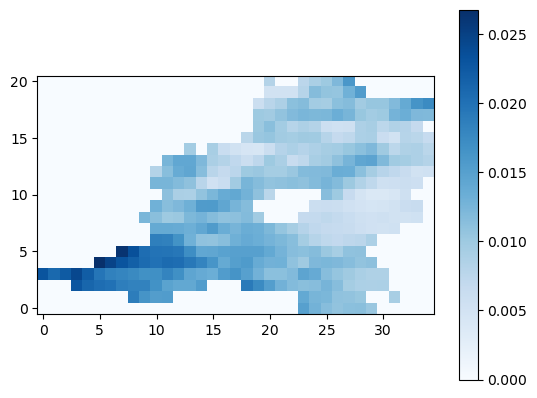

In [9]:
import matplotlib.pyplot as plt
import numpy as np

arr = np.nansum(clips[1].ro.values, axis=0)
print(arr.shape)
plt.imshow(arr, cmap='Blues', origin='lower')
plt.colorbar()

In [10]:
segment.iloc[2:5, :]

,id,OBJID,BEGINN,GF,NUTS_LEVEL,NUTS_CODE,NUTS_NAME,geometry,oid
2,3,DEBKGNU2000000D8,2022-12-20,4,1,DE3,Berlin,"MULTIPOLYGON (((13.48006 52.67465, 13.47879 52...",2
3,4,DEBKGNU2000000D9,2022-12-20,4,1,DE4,Brandenburg,"MULTIPOLYGON (((12.21908 52.86086, 12.21759 52...",3
4,5,DEBKGNU2000000DA,2022-12-20,4,1,DE5,Bremen,"MULTIPOLYGON (((8.61640 53.19703, 8.61522 53.1...",4


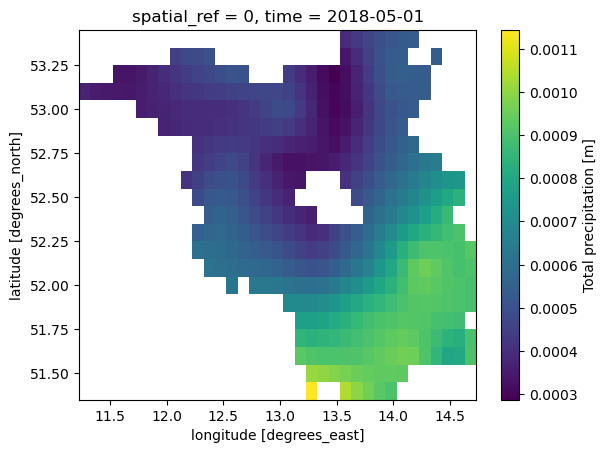

In [11]:
clips[1].isel(time=4).tp.plot.imshow()

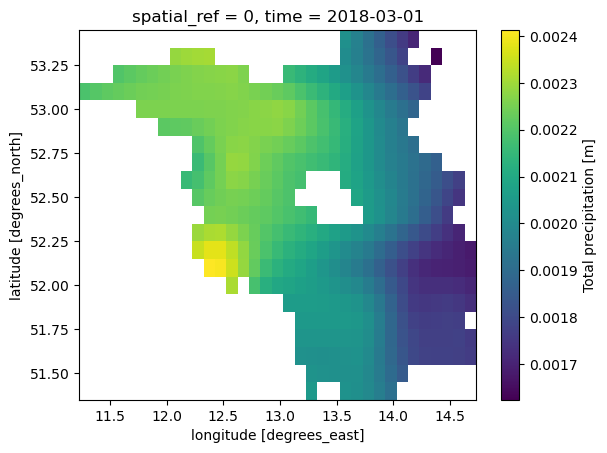

In [12]:
clips[1].isel(time=2).tp.plot.imshow()